1. Extract and Load Data

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

# Paths
zip_path = "archive (6).zip"
extract_path = "battery_data"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load metadata
metadata_path = os.path.join(extract_path, "cleaned_dataset", "metadata.csv")
metadata = pd.read_csv(metadata_path)


2. Process Impedance Data for 3D EIS Plot

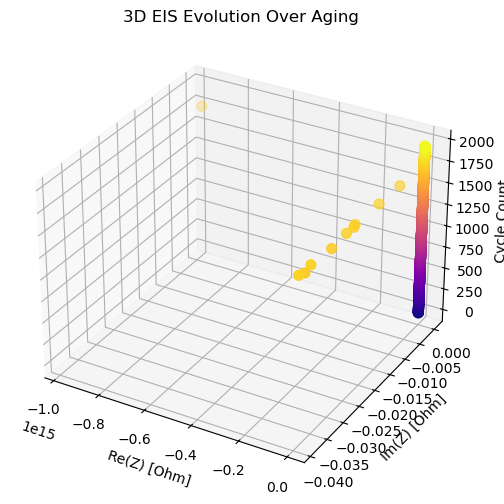

In [5]:
# Convert string to complex safely
def parse_complex(val):
    try:
        return complex(val.replace(" ", ""))
    except:
        return np.nan

# Parse complex numbers
impedance_metadata['Z_complex'] = impedance_metadata['Re'].apply(parse_complex)

# Drop any rows with invalid data
impedance_metadata.dropna(subset=['Z_complex'], inplace=True)

# Extract Re(Z) and Im(Z)
re_values = impedance_metadata['Z_complex'].apply(lambda z: z.real).values
im_values = impedance_metadata['Z_complex'].apply(lambda z: z.imag).values
cycles = np.arange(len(re_values))  # Aging axis

# Plot 3D EIS evolution
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(re_values, im_values, cycles, c=cycles, cmap='plasma', s=50)
ax.set_xlabel("Re(Z) [Ohm]")
ax.set_ylabel("Im(Z) [Ohm]")
ax.set_zlabel("Cycle Count")
ax.set_title("3D EIS Evolution Over Aging")
plt.show()


3. Incremental Capacity Analysis (dQ/dV vs V)

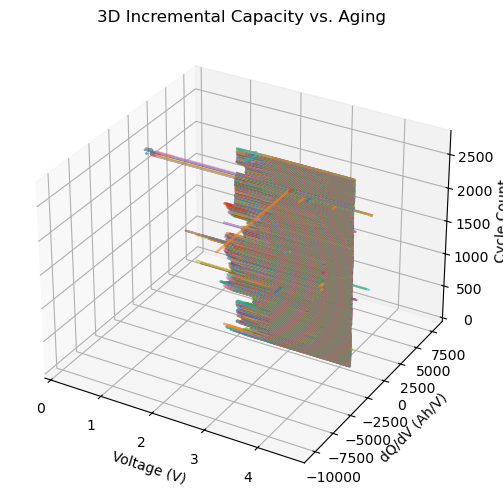

In [7]:
# Select discharge cycles only
discharge_metadata = metadata[metadata['type'] == 'discharge'].copy()
discharge_metadata['parsed_time'] = discharge_metadata['start_time'].apply(parse_start_time)
discharge_metadata.sort_values(by='parsed_time', inplace=True)
discharge_metadata.reset_index(drop=True, inplace=True)

# Function to calculate incremental capacity
def compute_dq_dv(file_path):
    df = pd.read_csv(file_path)
    voltage = df['Voltage_measured'].values
    current = df['Current_measured'].values
    time = df['Time'].values

    # Calculate capacity (Ah) using current over time
    capacity = np.cumsum(current * np.gradient(time)) / 3600  # Ah
    dq_dv = np.gradient(capacity) / np.gradient(voltage)

    return voltage[1:-1], dq_dv[1:-1]

# Plot 3D dQ/dV over aging
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

for idx, row in discharge_metadata.iterrows():
    file_path = os.path.join(extract_path, "cleaned_dataset", "data", row['filename'])
    try:
        v, dq_dv = compute_dq_dv(file_path)
        cycle_idx = np.full_like(v, idx)
        ax.plot(v, dq_dv, cycle_idx, alpha=0.6)
    except:
        continue

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dQ/dV (Ah/V)")
ax.set_zlabel("Cycle Count")
ax.set_title("3D Incremental Capacity vs. Aging")
plt.show()


4. Predict Capacity from EIS Using ML

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- Helper function to parse complex numbers from strings like '(0.08-0.03j)' ---
def parse_complex(x):
    try:
        return complex(x.replace(' ', '').replace('(', '').replace(')', '').replace('−', '-'))
    except:
        return np.nan

# --- Step 1: Parse complex impedance ---
impedance_metadata['Z_complex'] = impedance_metadata['Re'].apply(parse_complex)
impedance_metadata.dropna(subset=['Z_complex'], inplace=True)

# --- Step 2: Extract real and imaginary parts ---
X = pd.DataFrame()
X['Re'] = impedance_metadata['Z_complex'].apply(lambda z: z.real)
X['Im'] = impedance_metadata['Z_complex'].apply(lambda z: z.imag)

# --- Step 3: Add Cycle (Aging) feature ---
X['Cycle'] = np.arange(len(X))

# --- Step 4: Simulate Capacity (You must replace this with real data later) ---
X['Capacity'] = 2.0 - 0.0005 * X['Cycle']  # Linear synthetic degradation

# --- Step 5: Drop any remaining NaNs ---
X.dropna(inplace=True)

# --- Step 6: Split into features and target ---
y_clean = X['Capacity']
X_features = X[['Re', 'Im', 'Cycle']]

# --- Step 7: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_features, y_clean, test_size=0.2, random_state=42)

# --- Step 8: Train linear regression model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Step 9: Predict and evaluate ---
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# --- Final output ---
print("Shape of X:", X.shape)
print(f"Model MAE: {mae:.4f}")
print(f"Model R²: {r2:.4f}")


Shape of X: (1956, 4)
Model MAE: 0.0000
Model R²: 1.0000
